# Molecule hunter  
Locate a specific type of molecules after doing a grid search with the STM

#### Import needed modules

In [1]:
import pickle
import numpy as np
from math import ceil, floor

import matplotlib.pyplot as plt

from matplotlib_scalebar.scalebar import ScaleBar
from scipy.spatial.distance import cdist

from scipy.spatial import distance

from skimage.draw import polygon
from skimage.filters import gaussian, threshold_otsu, threshold_local
from skimage.measure import find_contours

#To do image analysis
import spiepy
# To locate molecules
import moleculelocator as molloc
# to open SPM images (Nanonis, Matrix)
from openimage import OpenImage
import spmanalysis as sa

## Start by opening a reference image
For now only one molecule should be on the reference image

In [2]:
reference_image = r"X:\Raw Data\2022\2022.10.25.LHe_Wtip_Au111_Nanocar99a_Tsublim_180C_10min\20221025-STM_Spectroscopy-Au111--448_1.Z_mtrx"

In [3]:
image_loader = OpenImage(0, "Z")

In [4]:
reference_image = image_loader.open_image(reference_image)

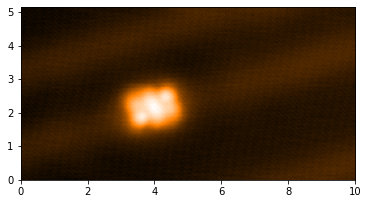

In [5]:
palette = spiepy.NANOMAP
palette.set_bad('r', 1.0)
width = reference_image.XY_width
height = reference_image.XY_height
plt.imshow(sa.flatten_xy(reference_image.data), cmap = palette, origin = 'lower', extent = (0, width, 0, height))
plt.show()

## Initialize the molecule locator, and get the details of the reference molecule 

In [6]:
locator = molloc.Locator()

In [7]:
parameters = {"resolution": 20, #px/nm
              "plane": 0,
              "min_separation": .5,
              "min_radius": .5,
              "gauss_blurr": 8}

In [8]:
locator.set_parameters(parameters)

In [9]:
print(locator.get_parameters())

{'resolution': 20, 'min_radius': 0.5, 'min_seperation': 1, 'offset': 0.0, 'plane': 0, 'gauss_blur': 8, 'line_filter_first': False, 'min_separation': 0.5, 'gauss_blurr': 8}


In [10]:
locator.get_reference(reference_image, chiral=False)

## Load Images to look for molecule

### For Matrix

In [11]:
filename = r"X:\Raw Data\2022\2022.10.25.LHe_Wtip_Au111_Nanocar99a_Tsublim_180C_10min\20221025-STM_Spectroscopy-Au111--448_1.Z_mtrx"

image_numbers = ("69_1", "114_1", "116_1", "124_1", "196_1", "280_1", "278_1", "284_1", "433_8", "435_1", "348_1")

descriptor = filename
extention = filename
descriptor = extention.partition("--")[0]
extention = extention.partition("--")[2]
extention = extention.partition(".")[2]

image_list = []
for i in image_numbers:
    image_list.append(image_loader.open_image(descriptor + "--" + i + "." + extention))

## Now do the actual locating

#### First, we locate all posibilities

In [12]:
_ = locator.transform(image_list)

### Calculate how similar they are to our reference

In [13]:
distance_matrix = cdist(np.array([x[0] for x in locator.ref_moments])[:, 0, :], 
      np.array([x[1] for x in locator.moments_list]))

### Now get the top X of smallest distances

In [14]:
def get_indices_of_k_smallest(arr, k):
    idx = np.argpartition(arr.ravel(), k)
    return tuple(np.array(np.unravel_index(idx, arr.shape))[:, range(min(k, 0), max(k, 0))])

In [15]:
top_x = 10
idx_n = get_indices_of_k_smallest(distance_matrix, top_x)[1]
namelist = [[x[0] for x in locator.moments_list][idx] for idx in idx_n]
circle_list = [[x[2] for x in locator.moments_list][idx] for idx in idx_n]

### Plot the top_x results for human comparison

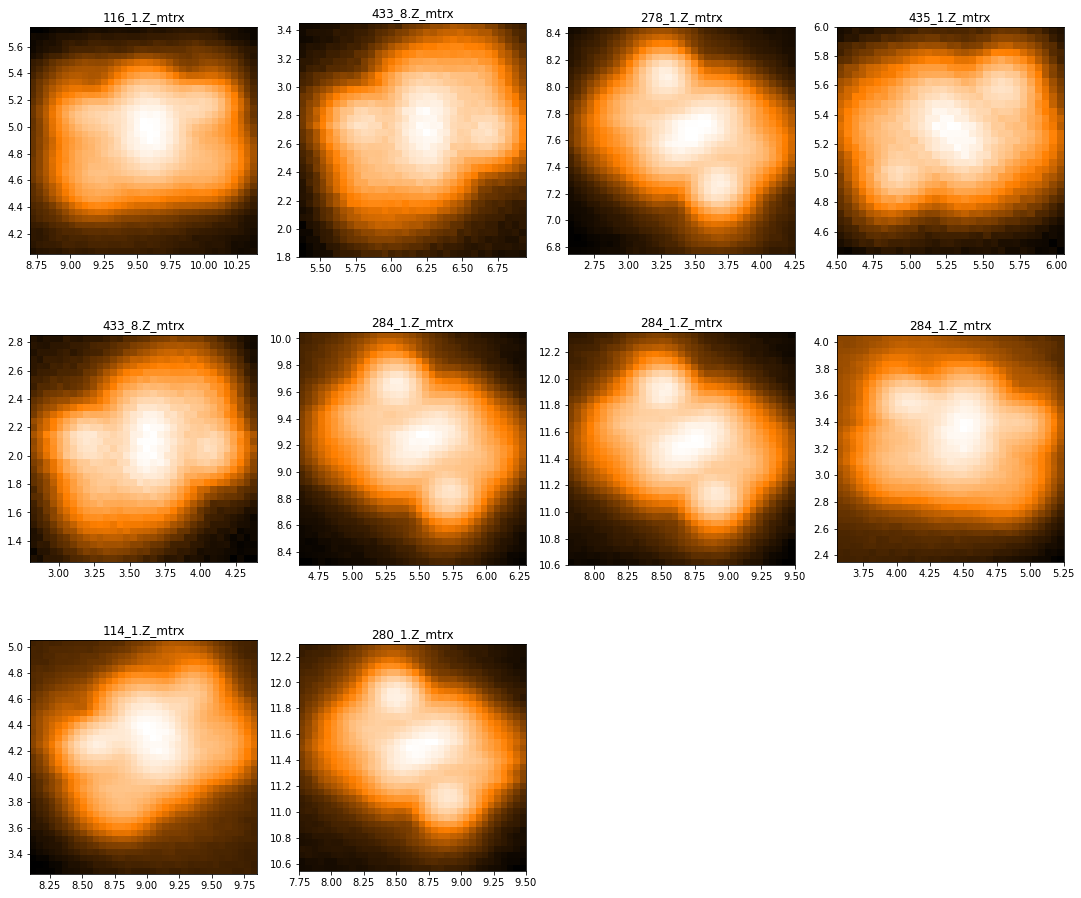

In [16]:
num_rows = ceil(len(idx_n)/4)

#prepare the figure with the size based on number of rows
fig = plt.figure(figsize=(15, (num_rows*4)+1))
palette = spiepy.NANOMAP
palette.set_bad('r', 1.0)
for i, name in enumerate(namelist):
    image = image_list[[image.name for image in image_list].index(name)]
    roi = locator.circle_to_roi(circle_list[i])
    roi_data = sa.draw_roi(image, roi)
    
    ax = fig.add_subplot(num_rows, 4, i+1)
    for g in range(1, 4):
        ax.imshow(roi_data, cmap = palette, origin = 'lower',
           extent = (roi[0][0], roi[1][0], roi[0][1], roi[1][1]), aspect=1)
        title = name.split("--")[-1]
        ax.set_title(title)
    
fig.tight_layout()
plt.show()